# Section 1 Libraries and Data

In [10]:
#!pip install poetry
#python 3(ipkernel)

In [11]:
#!pip install pystan==2.19.1.1
#!pip install numpy==1.21.1
#!pip install pandas==1.1.5
#!pip install matplotlib==3.4.3
#!pip install holidays==0.11.2
#!pip install fbprophet==0.7.1
#!pip install scikit-learn==0.24.2

In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet

import warnings
warnings.simplefilter('ignore')

In [2]:
#load the data
#YYYY-MM-DD
df = pd.read_csv('nyc_data.csv')
future_df = pd.read_csv('future.csv')
future_df.head()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2021,NaN,0,0,0,5.00,154.221
1,1/2/2021,NaN,0,0,0,11.11,264.805
2,1/3/2021,NaN,0,0,0,3.89,115.499
3,1/4/2021,NaN,0,0,0,6.67,124.650
4,1/5/2021,NaN,0,0,0,5.56,77.968


In [3]:
#merge both datasets
df = pd.concat([df, future_df])
df = df.reset_index(drop = True)
df.tail()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
2218,1/27/2021,NaN,0,0,0,3.33,39.664
2219,1/28/2021,NaN,0,0,0,1.67,195.314
2220,1/29/2021,NaN,0,0,0,-2.78,235.894
2221,1/30/2021,NaN,0,0,0,1.11,152.752
2222,1/31/2021,NaN,0,0,0,4.44,158.620


In [4]:
#Rename variable
df = df.rename(columns = {'Demand': 'y',
                          'Date': 'ds'})
df.head(0)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing


In [5]:
#Date variable
df.ds = pd.to_datetime(df.ds,
                       format = "%m/%d/%Y")
df.ds

0      2015-01-01
1      2015-01-02
2      2015-01-03
3      2015-01-04
4      2015-01-05
          ...    
2218   2021-01-27
2219   2021-01-28
2220   2021-01-29
2221   2021-01-30
2222   2021-01-31
Name: ds, Length: 2223, dtype: datetime64[ns]

# Section 2 Holidays

In [6]:
#Easter
dates = pd.to_datetime(df[df.Easter == 1].ds)
easter = pd.DataFrame({'holiday': 'easter',
                       'ds': dates,
                       'lower_window': -5,
                       'upper_window': 2})
easter

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2


In [7]:
#Thanksgiving
dates = pd.to_datetime(df[df.Thanksgiving == 1].ds)
thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',
                             'ds': dates,
                             'lower_window': -3,
                             'upper_window': 6})
thanksgiving

,holiday,ds,lower_window,upper_window
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6
1792,thanksgiving,2019-11-28,-3,6
2156,thanksgiving,2020-11-26,-3,6


In [8]:
#Combining events
holidays = pd.concat([easter, thanksgiving])
holidays

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6


In [9]:
#removing the holiday columns
df = df.drop(columns = ["Easter", "Thanksgiving"])
df.head(0)

,ds,y,Christmas,Temperature,Marketing


# Section 3 Facebook Prophet model

    Components                      Description
    1. Holidays                     Dataframe that we prepared
    2. Seasonality_mode             Multiplicative or additive
    3. Seasonality_prior_scale      Strength of the seasonality
    4. Holiday_prior_scale          Larger values allow the model to fit larger seasonal flucturations
    5. Changepoint_prior_scale      Does the Trend change easily?

In [10]:
#Split the data 
training = df.iloc[:-31,:] #The 'training' dataframe is created using all the rows except the last 31. 
future_df = df.iloc[-31:,:] #The 'future_df' dataframe is created using the last 31 rows of the original 'df' dataframe.

In [12]:
#Fetch the parameters
parameters = pd.read_csv("best_params_prophet.csv", 
                         index_col = 0)
parameters

,33
changepoint_prior_scale,0.01
holidays_prior_scale,5
seasonality_mode,additive
seasonality_prior_scale,5
rmse,48.12272129045956


In [13]:
#Extract the values
# if not using 'float()', it's a string
changepoint_prior_scale = float(parameters.loc["changepoint_prior_scale"][0])
holidays_prior_scale = float(parameters.loc["holidays_prior_scale"][0])
seasonality_prior_scale = float(parameters.loc["seasonality_prior_scale"][0])
seasonality_mode = parameters.loc["seasonality_mode"][0]

In [14]:
#FB model
m = Prophet(holidays = holidays,
            seasonality_mode = seasonality_mode,
            seasonality_prior_scale = seasonality_prior_scale,
            holidays_prior_scale = holidays_prior_scale,
            changepoint_prior_scale = changepoint_prior_scale)

m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.add_regressor('Marketing')

m.fit(training)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -13.7369


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5856.32    0.00127858         420.5      0.6714      0.6714      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       5861.81   0.000180112       363.961   2.444e-07       0.001      248  LS failed, Hessian reset 
     199       5862.17   0.000589589       394.376           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       5863.48   0.000328621       328.822   8.987e-07       0.001      361  LS failed, Hessian reset 
     299       5863.76   7.74241e-05       267.036           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        5863.9   6.16928e-06       297.256      0.2299           1      597   
    Iter      log prob        ||dx||      ||grad||       alpha

# Section 4 Forecasting

In [15]:
#make a future dataframe
future = m.make_future_dataframe(periods = len(future_df),
                                 freq = "D") #W for weekly or M for monthly
future = pd.concat([future, df.iloc[:,2:]], axis = 1)
future.tail()

,ds,Christmas,Temperature,Marketing
2218,2021-01-27,0,3.33,39.664
2219,2021-01-28,0,1.67,195.314
2220,2021-01-29,0,-2.78,235.894
2221,2021-01-30,0,1.11,152.752
2222,2021-01-31,0,4.44,158.620


In [16]:
#Forecasting
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,Marketing,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,595.661931,620.873823,763.132682,595.661931,595.661931,0.0,0.0,0.0,-3.453417,...,-4.036829,-4.036829,-4.036829,90.072193,90.072193,90.072193,0.0,0.0,0.0,689.059011
1,2015-01-02,595.775901,535.482922,675.345269,595.775901,595.775901,0.0,0.0,0.0,0.198138,...,-89.426824,-89.426824,-89.426824,88.702782,88.702782,88.702782,0.0,0.0,0.0,605.063079
2,2015-01-03,595.889871,650.340148,786.532851,595.889871,595.889871,0.0,0.0,0.0,1.457245,...,25.265354,25.265354,25.265354,87.498362,87.498362,87.498362,0.0,0.0,0.0,717.538080
3,2015-01-04,596.003841,565.077287,705.547308,596.003841,596.003841,0.0,0.0,0.0,1.359391,...,-55.628261,-55.628261,-55.628261,86.477987,86.477987,86.477987,0.0,0.0,0.0,632.080542
4,2015-01-05,596.117811,693.007809,831.304314,596.117811,596.117811,0.0,0.0,0.0,-3.058121,...,74.309324,74.309324,74.309324,85.655127,85.655127,85.655127,0.0,0.0,0.0,760.747232


<Figure size 1600x200 with 0 Axes>

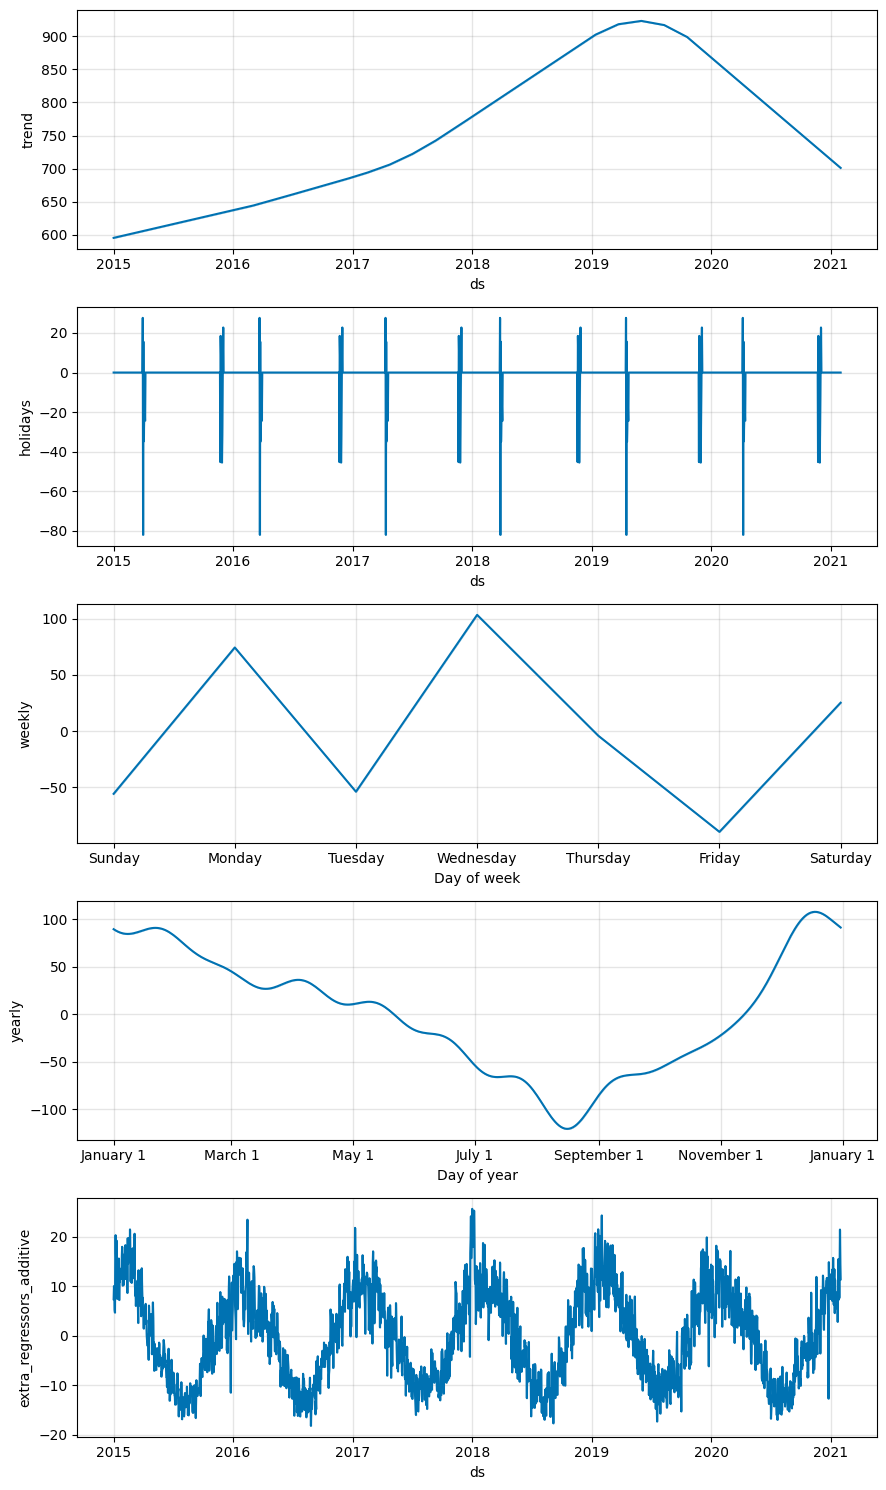

In [17]:
#Plotting
plt.figure(figsize=(16,2))
m.plot_components(forecast)
plt.show()

In [18]:
#extract the predictions
predictions_prophet = forecast.yhat[-len(future_df):].rename("prophet")
predictions_prophet.index = future_df["ds"]
predictions_prophet

ds
2021-01-01    724.460105
2021-01-02    836.084086
2021-01-03    754.505683
2021-01-04    880.816533
2021-01-05    750.764799
2021-01-06    913.210084
2021-01-07    800.902301
2021-01-08    721.552390
2021-01-09    830.827153
2021-01-10    745.412842
2021-01-11    880.019211
2021-01-12    754.456258
2021-01-13    902.881614
2021-01-14    802.552209
2021-01-15    712.557355
2021-01-16    828.728242
2021-01-17    749.222192
2021-01-18    879.298817
2021-01-19    748.270683
2021-01-20    905.114354
2021-01-21    800.656964
2021-01-22    709.140960
2021-01-23    830.120111
2021-01-24    754.337171
2021-01-25    875.213088
2021-01-26    752.698470
2021-01-27    902.121325
2021-01-28    801.189929
2021-01-29    720.031044
2021-01-30    825.835864
2021-01-31    740.054893
Name: prophet, dtype: float64

In [19]:
#export
predictions_prophet.to_csv("predictions_prophet.csv")